## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

## Getting the data

The planet dataset isn't available on the [fastai dataset page](https://course.fast.ai/datasets) due to copyright restrictions. You can download it from Kaggle however. Let's see how to do this by using the [Kaggle API](https://github.com/Kaggle/kaggle-api) as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add `source activate fastai` or similar, or prefix `pip` with a path. Have a look at how `conda install` is called for your platform in the appropriate *Returning to work* section of https://course-v3.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [5]:
# ! sudo pip install kaggle --upgrade

Then you need to upload your credentials from Kaggle on your instance. Login to kaggle and click on your profile picture on the top left corner, then 'My account'. Scroll down until you find a button named 'Create New API Token' and click on it. This will trigger the download of a file named 'kaggle.json'.

Upload this file to the directory this notebook is running in, by clicking "Upload" on your main Jupyter page, then uncomment and execute the next two commands (or run them in a terminal).

In [6]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

You're all set to download the data from [planet competition](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). You **first need to go to its main page and accept its rules**, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a `403 forbidden` error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on *Rules* tab, and then scroll to the bottom to find the *accept* button).

In [3]:
path = Config.data_path()/'planet'
path.mkdir(exist_ok=True)
path

PosixPath('/home/jupyter/.fastai/data/planet')

In [9]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

train-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


To extract the content of this file, we'll need 7zip, so uncomment the following line if you need to install it (or run `sudo apt install p7zip` in your terminal).

In [12]:
# ! conda install -y -c haasad eidl7zip

And now we can unpack the data (uncomment to run - this might take a few minutes to complete).

In [13]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path}

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageMultiDataset` (and not `ImageClassificationDataset`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [7]:
data = (src.transform(tfms, size=128 )
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

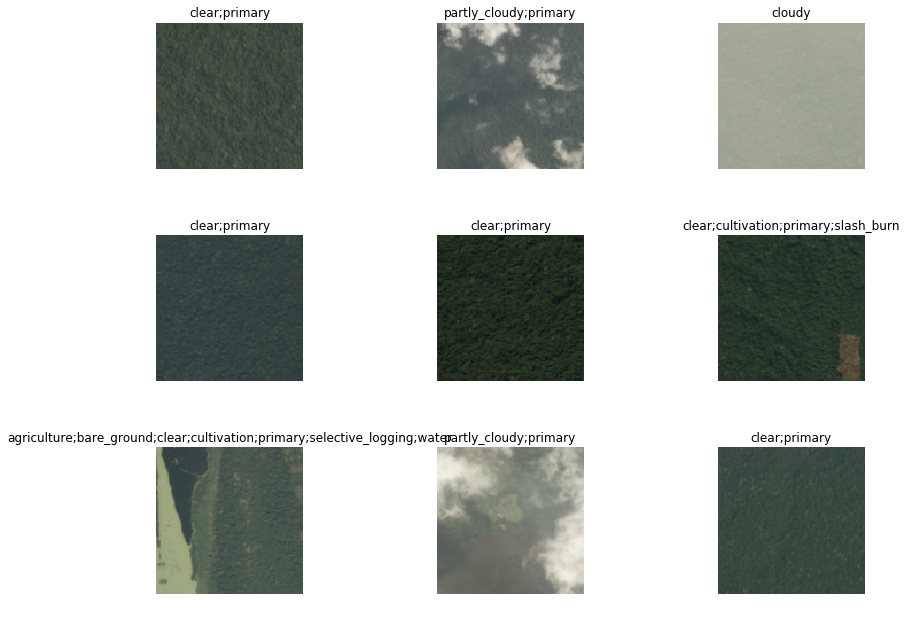

In [8]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [8]:
arch = models.resnet50

In [10]:
data.c

17

Sve sto je vece od nekog tresholda (thresh=0.2) predpostavicemo da model ima taj feature

In [11]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


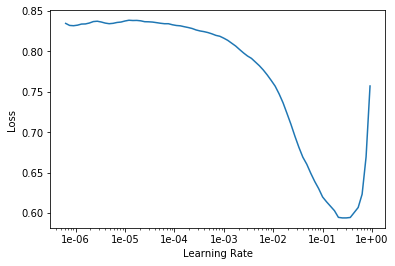

In [13]:
learn.recorder.plot()

Then we can fit the head of our network.

In [14]:
lr = 0.01

In [15]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.122897,0.108424,0.946002,0.904587
2,0.108306,0.101756,0.955397,0.910643
3,0.099761,0.091038,0.953348,0.920888
4,0.097032,0.087892,0.956073,0.922464
5,0.090933,0.086613,0.955390,0.924709


In [16]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [17]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


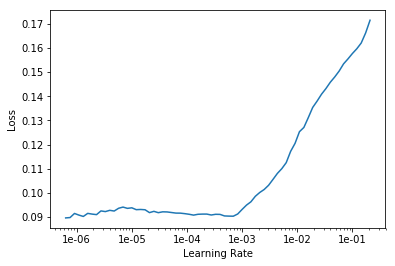

In [18]:
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.096499,0.091497,0.952832,0.920586
2,0.097047,0.089371,0.955172,0.920990
3,0.090819,0.085344,0.955848,0.926735
4,0.082952,0.083257,0.958224,0.926803
5,0.079233,0.082521,0.958100,0.928071


In [20]:
learn.save('stage-2-rn50')

In [12]:
learn.load('stage-2-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (32384 items)
[MultiCategory haze;primary, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory haze;primary;water, MultiCategory agriculture;clear;cultivation;primary;water]...
Path: /home/jupyter/.fastai/data/planet
x: ImageItemList (32384 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (8095 items)
[MultiCategory clear;primary;road, MultiCategory clear;primary;water, MultiCategory clear;conventional_mine;habitation;primary;road;water, MultiCategory cloudy, MultiCategory agriculture;clear;cultivation;cultivation;habitation;primary;road;water]...
Path: /home/jupyter/.fastai/data/planet
x: ImageItemList (8095 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data

In [14]:
data = (src.transform(tfms, size=256, )
        .databunch(bs=16).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [15]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


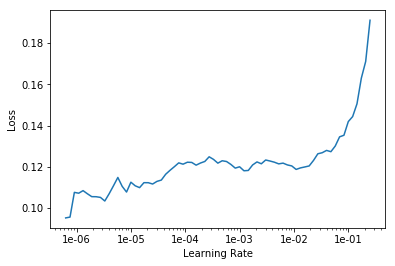

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
lr=1e-2/2

In [18]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.098862,0.088734,0.959001,0.921831
2,0.103273,0.095793,0.955339,0.915449
3,0.097766,0.087193,0.957614,0.924153
4,0.089232,0.089989,0.959481,0.926547
5,0.088146,0.110741,0.961428,0.927252


In [19]:
learn.save('stage-1-256-rn50')

In [20]:
learn.unfreeze()

In [21]:
learn.fit_one_cycle(3, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.098209,0.293597,0.955274,0.920981
2,0.095572,0.103864,0.957948,0.925819
3,0.089073,0.089634,0.959307,0.925664


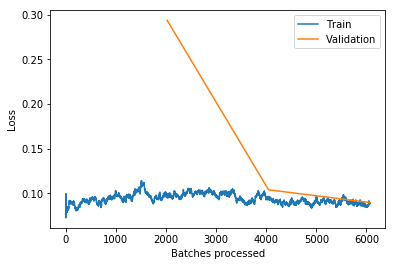

In [23]:
learn.recorder.plot_losses()

In [22]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [60]:
# !rm -rf {path}/test-jpg

In [61]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  

test-jpg.tar.7z: Skipping, found more recently modified local copy (use --force to force download)


In [62]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [71]:
!ls {path}/test-jpg | wc

  40669   40669  598925


In [64]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}

test-jpg-additional.tar.7z: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
! 7za -bd -y x {path}/test-jpg-additional.tar.7z -o{path}
! tar -xf {path}/test-jpg-additional.tar -C {path}

! rsync -aP {path}test-jpg-additional/ {path}test-jpg/


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,8 CPUs x64)

Scanning the drive for archives:
1 file, 318407195 bytes (304 MiB)

Extracting archive: /home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z
--
Path = /home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z
Type = 7z
Physical Size = 318407195
Headers Size = 98
Method = LZMA2:24
Solid = -
Blocks = 1

Everything is Ok

Size:       336865280
Compressed: 318407195
sending incremental file list
rsync: change_dir "/home/jupyter/.fastai/data/planettest-jpg-additional" failed: No such file or directory (2)
rsync error: some files/attrs were not transferred (see previous errors) (code 23) at main.c(1196) [sender=3.1.2]


In [72]:
! mv {path}/test-jpg-additional/* {path}/test-jpg

In [73]:
!ls {path}/test-jpg | wc

  61191   61191  895645


In [74]:
learn.load('stage-2-256-rn50')

Learner(data=ImageDataBunch;

Train: LabelList
y: MultiCategoryList (36432 items)
[MultiCategory haze;primary, MultiCategory agriculture;clear;primary;water, MultiCategory clear;primary, MultiCategory clear;primary, MultiCategory agriculture;clear;habitation;primary;road]...
Path: /home/jupyter/.fastai/data/planet
x: ImageItemList (36432 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data/planet;

Valid: LabelList
y: MultiCategoryList (4047 items)
[MultiCategory clear;primary, MultiCategory agriculture;clear;primary;water, MultiCategory clear;primary, MultiCategory cloudy, MultiCategory clear;primary]...
Path: /home/jupyter/.fastai/data/planet
x: ImageItemList (4047 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: /home/jupyter/.fastai/data/planet;

Test: LabelList
y: MultiCategoryList (40669 items)
[MultiCategory haze

In [75]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

In [76]:
len(learn.data.test_ds)

61191

In [77]:
predictions = learn.get_preds(ds_type=DatasetType.Test)

In [78]:
torch.save(predictions,'predictions_sz_256.pt')

In [79]:
predictions

[tensor([[7.4250e-02, 2.6842e-04, 1.2322e-03,  ..., 4.2929e-05, 1.0867e-04,
          9.9454e-01],
         [4.4273e-05, 2.6824e-08, 9.0673e-07,  ..., 7.7227e-06, 1.2203e-06,
          1.6625e-05],
         [3.6836e-02, 8.0616e-05, 9.5896e-04,  ..., 1.4579e-04, 3.7392e-04,
          4.6693e-01],
         ...,
         [9.6036e-01, 1.4725e-05, 5.2614e-03,  ..., 4.3552e-04, 5.6674e-03,
          3.3149e-02],
         [1.2620e-04, 5.1279e-06, 5.0502e-05,  ..., 5.3412e-06, 2.3955e-05,
          6.4083e-04],
         [4.7386e-03, 2.6764e-05, 4.0174e-04,  ..., 3.3862e-05, 2.5569e-05,
          8.7851e-02]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]])]

In [80]:
len(predictions[0])

61191

shamelessly stolen from
https://nbviewer.jupyter.org/github/arunoda/fastai-courses/blob/master/dl1/lesson3-planet.ipynb#Test-Dataset

In [82]:
def find_tags(pred, thresh):
    classes = ""
    for idx, val in enumerate(pred):
        if val > thresh:
            classes = f'{classes} {learn.data.classes[idx]}'
    return classes.strip()

In [83]:
def predict(idx):
    pred_vals = predictions[0][idx]
    tags = find_tags(pred_vals, 0.2)
    print(tags)
    img = learn.data.test_ds[idx][0]
    return img

clear primary water


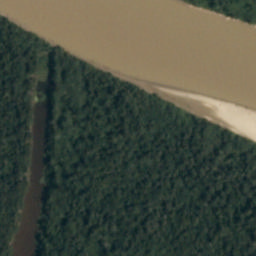

In [84]:
predict(0)

In [85]:
def get_row(idx):
    pred = predictions[0][idx]
    tags = find_tags(pred, 0.2)
    image_path = learn.data.test_ds.x.items[idx]
    image_name = re.search(r'([^/]+)$', f'{image_path}')[0].replace('.jpg', '')
    
    return image_name, tags

In [86]:
get_row(4)

('test_34419', 'clear cloudy water')

In [87]:
df = pd.DataFrame(columns=['image_name', 'tags'])
for idx in range(len(predictions[0])):
    if idx % 5000 == 0:
        print(f"Completed: {idx}")
        
    image_name, tags = get_row(idx)
    df.loc[idx] = [image_name, tags]

Completed: 0
Completed: 5000
Completed: 10000
Completed: 15000
Completed: 20000
Completed: 25000
Completed: 30000
Completed: 35000
Completed: 40000
Completed: 45000
Completed: 50000
Completed: 55000
Completed: 60000


In [88]:
df.head()

,image_name,tags
0,file_11457,clear primary water
1,test_17412,clear primary
2,file_11115,cloudy partly_cloudy primary water
3,test_17884,agriculture partly_cloudy primary road
4,test_34419,clear cloudy water


In [94]:
df.to_csv(path/"submission.csv", index=False)

In [98]:
! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f {path}/submission.csv -m "Message"

  0%|                                               | 0.00/2.18M [00:00<?, ?B/s]
'file' object has no attribute 'readable'
Could not submit to competition

In [ ]:
To do so, run the command `kaggle competitions submit -c [COMPETITION NAME] -f [FILE PATH].